In [1]:
import torch 
import torch.nn as nn
torch.__version__

'2.1.1'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

In [75]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    pass
else:
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)

In [76]:
import os
def walk_through_data(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        pass

In [77]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [78]:
import random
from PIL import Image
random.seed(23)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)


(-0.5, 511.5, 340.5, -0.5)

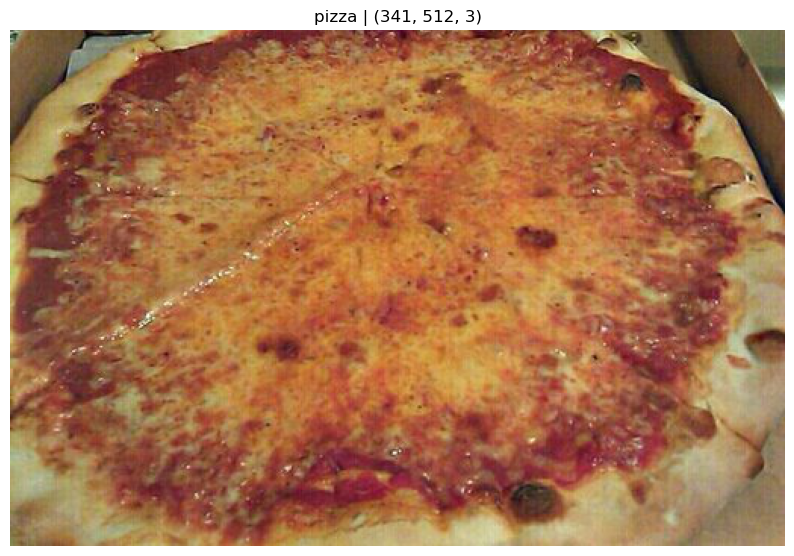

In [79]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"{image_class} | {img_as_array.shape}")
plt.axis(False)

In [80]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [81]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

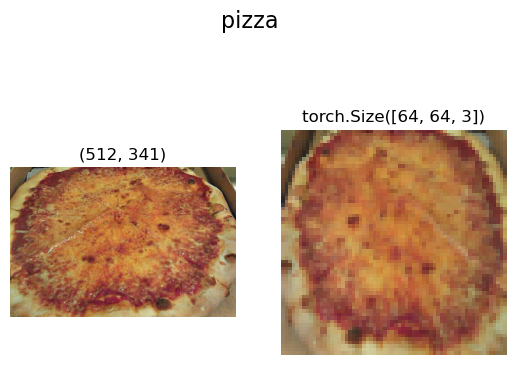

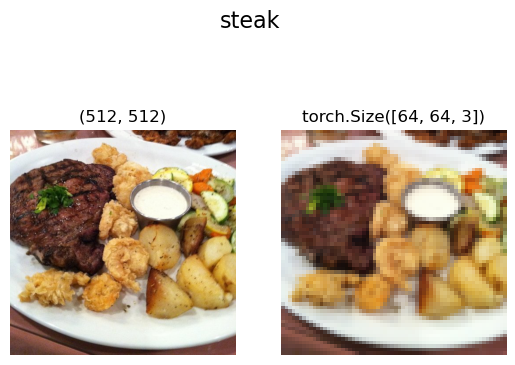

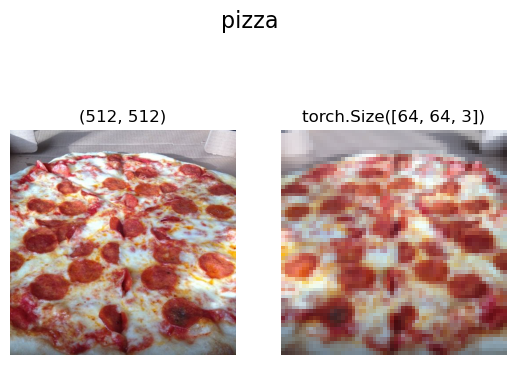

In [82]:
def plot_transformed_images(img_paths, transform, n=3, seed=23):
    random.seed(seed)
    random_image_paths = random.sample(img_paths, k=n)
    for img_path in random_image_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"{f.size}")
            ax[0].axis(False)

            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"{transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"{img_path.parent.stem}", fontsize=16)

plot_transformed_images(img_paths=image_path_list,
                        transform=data_transform,
                        n=3)

In [83]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [84]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [85]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [86]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [87]:
img, label = train_data[0][0], train_data[0][1]

In [88]:
img_permuted = img.permute(1, 2, 0)

Text(0.5, 1.0, 'pizza')

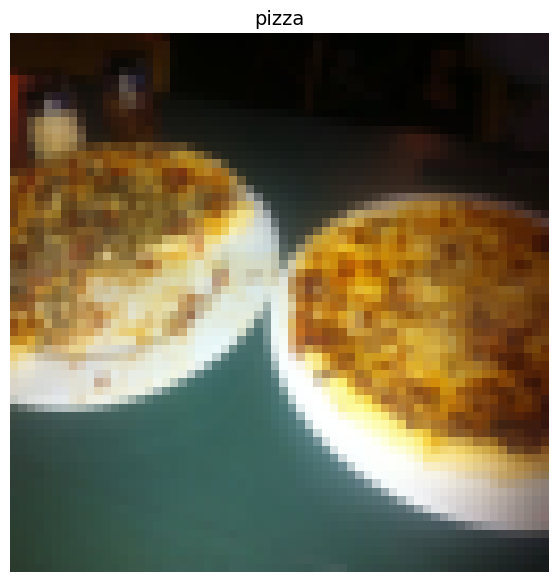

In [89]:
plt.figure(figsize=(10, 7))
plt.imshow(img_permuted)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [90]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, 
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=1,
                             shuffle=False)

In [91]:
img, label = next(iter(train_dataloader))


In [92]:
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [93]:
target_directory = train_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [94]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [95]:
def find_classes(directory):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError("not found")
    
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [96]:
class Data(Dataset):
    def __init__(self, target_dir, transform=None):
        self.paths = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)

    def load_image(self, index):
        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        
        return img, class_idx

In [97]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [98]:
train_data_custom = Data(target_dir=train_dir,
                          transform=train_transform)
test_data_custom = Data(target_dir=test_dir,
                         transform=test_transform)

In [99]:
train_data_custom, test_data_custom

(<__main__.Data at 0x26dd82b0810>, <__main__.Data at 0x26dd51f3190>)

In [100]:
len(train_data), len(train_data_custom)

(225, 225)

In [101]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [102]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [103]:
def display_random_images(dataset, classes, n=10, display_shape=True, seed=23):
    if n > 10:
        n = 10
        display_shape = False
    random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, target_sample in enumerate(random_samples_idx):
        target_img, target_label = dataset[target_sample][0], dataset[target_sample][1]

        target_image_adjust = target_img.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[target_label]}"
            if display_shape:
                title = title + f"\nshape:{target_image_adjust.shape}"

        plt.title(title)

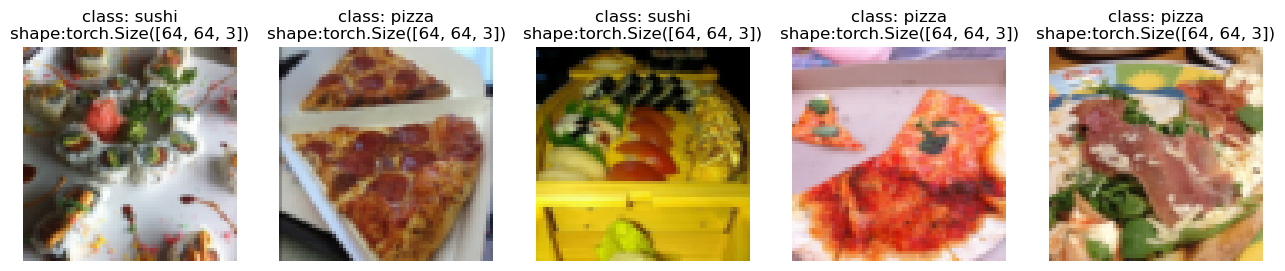

In [104]:
display_random_images(train_data, n=5, classes=class_names, seed=23)

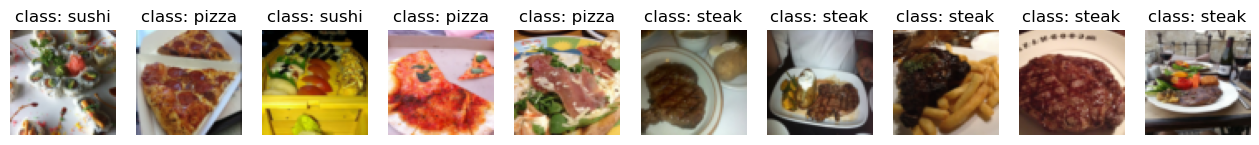

In [105]:
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=23)

In [106]:
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                      batch_size=32,
                                      num_workers=0,
                                      shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=32,
                                    num_workers=0,
                                    shuffle=True)

In [107]:
img_custom, label_custom = next(iter(train_dataloader_custom))

In [108]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [109]:
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

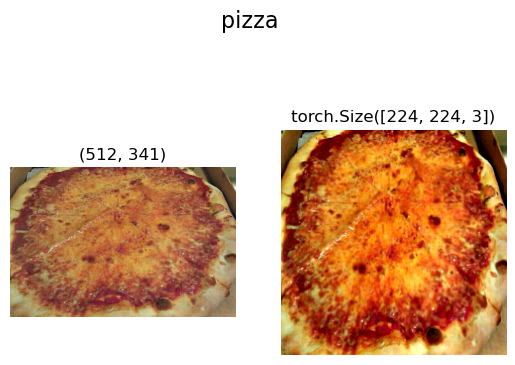

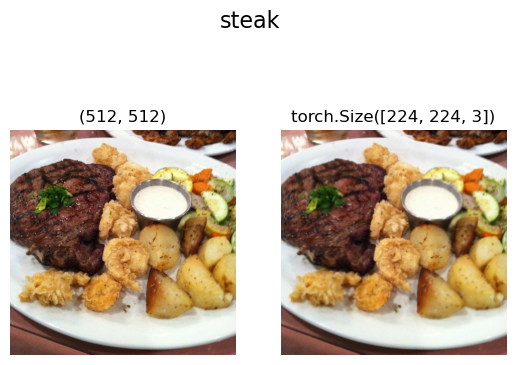

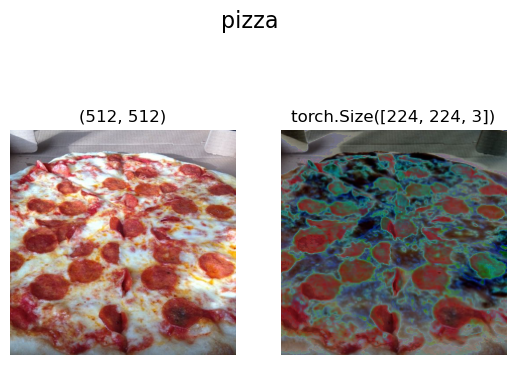

In [110]:
plot_transformed_images(img_paths=image_path_list, transform=train_transform, n=3)

In [111]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [112]:
# load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

In [113]:
import os
from torch.utils.data import DataLoader

In [115]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [123]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.out = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.out(x)
        return x

In [120]:
torch.manual_seed(23)
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

In [121]:
image_batch, label_batch = next(iter(train_dataloader_simple))

In [124]:
model(image_batch.to(device))

tensor([[ 0.0131,  0.0108,  0.0014],
        [ 0.0147,  0.0095,  0.0073],
        [ 0.0115,  0.0134,  0.0064],
        [ 0.0112,  0.0094,  0.0022],
        [ 0.0116,  0.0087,  0.0033],
        [ 0.0138,  0.0116,  0.0041],
        [ 0.0170,  0.0115,  0.0044],
        [ 0.0107,  0.0115,  0.0020],
        [ 0.0147,  0.0092,  0.0030],
        [ 0.0171,  0.0111,  0.0041],
        [ 0.0139,  0.0091,  0.0031],
        [ 0.0128,  0.0071,  0.0049],
        [ 0.0154,  0.0064, -0.0015],
        [ 0.0138,  0.0059,  0.0025],
        [ 0.0094,  0.0114,  0.0029],
        [ 0.0149,  0.0074,  0.0033],
        [ 0.0133,  0.0097,  0.0027],
        [ 0.0155,  0.0135,  0.0052],
        [ 0.0117,  0.0136,  0.0040],
        [ 0.0177,  0.0146,  0.0053],
        [ 0.0163,  0.0110,  0.0007],
        [ 0.0170,  0.0127,  0.0034],
        [ 0.0123,  0.0079,  0.0050],
        [ 0.0202,  0.0145,  0.0045],
        [ 0.0151,  0.0110,  0.0033],
        [ 0.0150,  0.0125,  0.0055],
        [ 0.0159,  0.0115,  0.0024],
 

In [126]:
from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64])

ModuleNotFoundError: No module named 'torchinfo'

In [127]:
def train_step(model, dataloader, loss_fn, optimizer, device=device):
    model.train()

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [128]:
def test_step(model, dataloader, loss_fn, device=device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_label = torch.argmax(test_pred_logits, dim=1)
            test_acc += (test_pred_label == y).sum().item() / len(test_pred_label)

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [129]:
from tqdm.auto import tqdm

In [130]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(f"epoch: {epoch} | ...")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [131]:
NUM_EPOCHS = 5

model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [132]:
from timeit import default_timer as timer

In [134]:
start_time = timer()
model_results = train(model, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, epochs=NUM_EPOCHS, device = 'cuda')
end_time = timer()
print(end_time - start_time)

  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: "host_softmax" not implemented for 'Long'

In [135]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, lable="test_loss")
    plt.title('Loss')
    plt.xlable('epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="train_acc")
    plt.plot(epochs, test_loss, lable="test_acc")
    plt.title('Acc')
    plt.xlable('epochs')
    plt.legend()

In [ ]:
plot_loss_curves(model_results)

In [136]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [137]:
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir, transform=test_transform_trivial)

In [138]:
train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_augmented = DataLoader(dataset=test_data_augmented, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [140]:
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)

In [141]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
model_results = train(model, train_dataloader_augmented, test_dataloader_augmented, optimizer, loss_fn, NUM_EPOCHS, device)

In [ ]:
plot_loss_curves(model)

In [ ]:
import pandas as pd
model_df = pd.DataFrame(model_results)

In [142]:
import requests

In [ ]:
custom_image_path = data_path / "04-pizza-dad.jpeg"
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("url")
        f.write(request.content)

In [ ]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

In [ ]:
custom_image_transformed = custom_image_transform(custom_image_uint8)

In [ ]:
# error: no batch size
model.eval()
with torch.no_grad():
    model(custom_image_uint8.to(device))

In [ ]:
custom_image_uint8 = custom_image_uint8.unsqueeze(0)

In [ ]:
model.eval()
with torch.no_grad():
    custom_image_pred = model(custom_image_uint8.to(device))

In [ ]:
custom_image_pred_label = torch.argmax(torch.softmax(custom_image_pred, dim=1), dim=1).cpu()

In [ ]:
def pred_and_plot_image(model, image_path, class_names, transform, device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image /= 255.

    if transform:
        target_image = transform(target_image)

    model.to(device)

    model.eval()
    with torch.no_grad():
        target_image = target_image.unsqueeze(0)
        target_image_pred = model(target_image.to(device))

    target_image_pred_labels = torch.argmax(torch.softmax(target_image_pred, dim=1), dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0))

    if class_names:
        title = f"pred: {class_names[target_image_pred_labels.cpu()]}" # plt only on cpu

    else:
        title = f"pred: {target_image_pred_labels}"

    plt.title(title)
    plt.axis(False)